# Anomaly Detection & Anomaly Score Analysis

Notebook ini menganalisis performa dan distribusi **anomaly score** (IsolationForest/LOF/Autoencoder).

Fitur utama:
- Hitung anomaly score dari data train, lalu apply ke val/test (leakage-free)
- Plot distribusi score per kelas (fraud/non-fraud)
- Evaluasi PR-AUC/ROC-AUC berbasis score
- Lihat Lift@Top-K berdasarkan anomaly score

In [ ]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import average_precision_score, roc_auc_score



from loader.data_loader import UniversalDataLoader
from model.anomaly import add_anomaly_scores
from evaluation.metrics import lift_at_top_k

sns.set_style('whitegrid')

DATA_PATH = "/Users/rudyhendrawan/Projects/data"
DATASET_NAME = os.environ.get('DATASET_NAME', '03_fraud_oracle.csv')
DATA_ROOT = os.environ.get('DATA_ROOT', DATA_PATH)
ANOMALY_METHOD = os.environ.get('ANOMALY_METHOD', 'IsolationForest')
CONTAMINATION = float(os.environ.get('CONTAMINATION', '0.01'))
RANDOM_STATE = int(os.environ.get('RANDOM_STATE', '42'))

print('Dataset:', DATASET_NAME)
print('Anomaly method:', ANOMALY_METHOD)

Dataset: 03_fraud_oracle.csv
Anomaly method: IsolationForest


In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
loader = UniversalDataLoader(
    DATASET_NAME,
    project_root=project_root,
    data_root=DATA_ROOT,
    verbose=False,
    large_data=False,
)
X_train, X_val, X_test, y_train, y_val, y_test, _ = loader.train_val_test_split()
print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

INFO:loader.data_loader:Initialized loader for: Vehicle Claim Fraud
INFO:loader.data_loader:Data path: /Users/rudyhendrawan/Projects/data/03_fraud_oracle.csv
INFO:loader.data_loader:Loaded raw data: 15420 rows, 33 columns
INFO:loader.data_loader:Class distribution: {0: 14497, 1: 923}
INFO:loader.data_loader:Using stratified shuffle split.
INFO:loader.data_loader:
Data split:
INFO:loader.data_loader:. Train: 9252 samples | Class distribution: {0: 0.9401210549070471, 1: 0.05987894509295288}
INFO:loader.data_loader:. Validation: 3084 samples | Class distribution: {0: 0.9400129701686122, 1: 0.05998702983138781}
INFO:loader.data_loader:. Test: 3084 samples | Class distribution: {0: 0.940337224383917, 1: 0.05966277561608301}


Train: (9252, 32) Val: (3084, 32) Test: (3084, 32)


In [3]:
X_train_s, X_val_s, X_test_s = add_anomaly_scores(
    X_train, X_val, X_test,
    method=ANOMALY_METHOD,
    random_state=RANDOM_STATE,
    contamination=CONTAMINATION
)

score_col = [c for c in X_train_s.columns if c.startswith('anomaly_score_')]
if not score_col:
    raise ValueError('Anomaly score column not found')
score_col = score_col[0]
print('Score column:', score_col)

Score column: anomaly_score_isolationforest


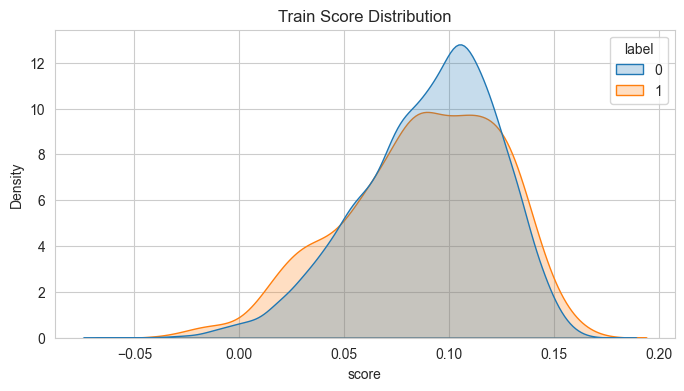

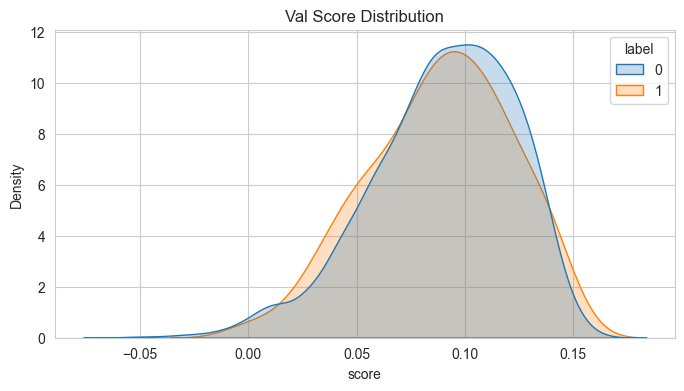

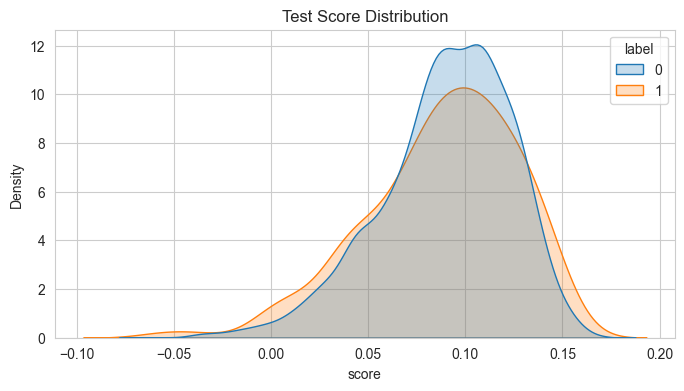

In [4]:
def plot_score_distribution(X, y, title):
    df = pd.DataFrame({
        'score': X[score_col].values,
        'label': y.values if isinstance(y, pd.Series) else y
    })
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x='score', hue='label', fill=True, common_norm=False)
    plt.title(title)
    plt.show()

plot_score_distribution(X_train_s, y_train, 'Train Score Distribution')
plot_score_distribution(X_val_s, y_val, 'Val Score Distribution')
plot_score_distribution(X_test_s, y_test, 'Test Score Distribution')

In [5]:
def eval_scores(y_true, scores, name):
    pr = average_precision_score(y_true, scores)
    roc = roc_auc_score(y_true, scores)
    lift = lift_at_top_k(y_true, scores, 0.01)
    print(f'{name} PR-AUC: {pr:.4f}')
    print(f'{name} ROC-AUC: {roc:.4f}')
    print(f'{name} Lift@Top1%: {lift:.4f}')

eval_scores(y_train, X_train_s[score_col].values, 'Train')
eval_scores(y_val, X_val_s[score_col].values, 'Val')
eval_scores(y_test, X_test_s[score_col].values, 'Test')

Train PR-AUC: 0.0623
Train ROC-AUC: 0.4854
Train Lift@Top1%: 1.4522
Val PR-AUC: 0.0602
Val ROC-AUC: 0.4831
Val Lift@Top1%: 0.5557
Test PR-AUC: 0.0642
Test ROC-AUC: 0.4929
Test Lift@Top1%: 0.5587


## Notes
- Jika distribusi skor kelas fraud dan non-fraud tumpang tindih besar, anomaly model kurang efektif.
- Coba ganti `ANOMALY_METHOD` ke `LOF` atau `Autoencoder` untuk perbandingan.